# Lendo Parquet (S3)

In [1]:
import sys
!{sys.executable} -m pip install pyarrow

    100% |████████████████████████████████| 48.5MB 13kB/s  eta 0:00:01
You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [46]:
import s3fs
import pyarrow.parquet as pq
from pyarrow.filesystem import S3FSWrapper

fs = s3fs.S3FileSystem()
bucket = "treinamento-big-data-aws"
path = "Turma_20190701/BrunoJ/ABT_NUMERICAS"

# Python 3.6 or later
p_dataset = pq.ParquetDataset(
    f"s3://{bucket}/{path}",
    filesystem=fs
)
df = p_dataset.read().to_pandas()

df.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,...,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,TARGET
0,202500.0,406597.5,24700.5,351000.0,0.018801,-3648.0,NaN,1.0,0.083037,0.262949,...,0,0,0,0,0,0,0,0,0,1
1,270000.0,1293502.5,35698.5,1129500.0,0.003541,-1186.0,NaN,2.0,0.311267,0.622246,...,0,0,0,0,0,0,0,0,0,0
2,67500.0,135000.0,6750.0,135000.0,0.010032,-4260.0,26.0,1.0,NaN,0.555912,...,0,0,0,0,0,0,0,0,0,0
3,135000.0,312682.5,29686.5,297000.0,0.008019,-9833.0,NaN,2.0,NaN,0.650442,...,0,0,0,0,0,0,0,0,0,0
4,121500.0,513000.0,21865.5,513000.0,0.028663,-4311.0,NaN,1.0,NaN,0.322738,...,0,0,0,0,0,0,0,0,0,0


# Gerando Metadados 

In [47]:
def AjusteMetadados(dataframe): 
    import pandas as pd
    train = dataframe
    # Verifica os tipos de variáveis presentes na tabela de treino
    t = []
    for i in train.columns:
            t.append(train[i].dtype)

    n = []
    for i in train.columns:
            n.append(i)

    aux_t = pd.DataFrame(data=t,columns=["Tipos"])
    aux_n = pd.DataFrame(data=n,columns=["Features"])
    df_tipovars = pd.concat([aux_n, aux_t], axis=1, join_axes=[aux_n.index])

    data = []
    for f in train.columns:

        # Definindo o papel das variáveis:
        if f == 'target':
            role = 'target'
        elif f == 'id':
            role = 'id'
        else:
            role = 'input'

        # Definindo o tipo das variáveis: nominal, ordinal, binary ou interval
        if f == 'target':
            level = 'binary'
        if train[f].dtype == 'object' or f == 'id': 
            level = 'nominal'
        elif train[f].dtype in ['float','float64'] :
            level = 'interval'
        elif train[f].dtype in ['int','int64','int32'] :
            level = 'ordinal'
        else:
            level = 'NA'

        # Todas variáveis são incializadas com keep exceto o id
        keep = True
        if f == 'id':
            keep = False

        # Definindo o tipo das variáveis da tabela de entrada
        dtype = train[f].dtype

        # Criando a lista com todo metadados
        f_dict = {
            'Features': f,
            'Role': role,
            'Level': level,
            'Keep': keep,
            'Tipo': dtype
        }
        data.append(f_dict)

    meta = pd.DataFrame(data, columns=['Features', 'Role', 'Level', 'Keep', 'Tipo'])

    # Quantidade de domínios distintos para cada cariável do tipo ordinal e nominal
    card = []

    v = train.columns
    for f in v:
        dist_values = train[f].value_counts().shape[0]
        f_dict = {
                'Features': f,
                'Cardinality': dist_values
            }
        card.append(f_dict)

    card = pd.DataFrame(card, columns=['Features', 'Cardinality'])

    metadados_train = pd.merge(meta, card, on='Features')

    return metadados_train 

In [48]:
# Vamos renomear as variáveis PassengerId e Survived
df.rename(columns={'SK_ID_CURR': 'id', 'TARGET': 'target'}, inplace=True)

In [49]:
metadados = AjusteMetadados(df)
metadados

,Features,Role,Level,Keep,Tipo,Cardinality
0,AMT_INCOME_TOTAL,input,interval,True,float64,2548
1,AMT_CREDIT,input,interval,True,float64,5603
2,AMT_ANNUITY,input,interval,True,float64,13672
3,AMT_GOODS_PRICE,input,interval,True,float64,1002
4,REGION_POPULATION_RELATIVE,input,interval,True,float64,81
5,DAYS_REGISTRATION,input,interval,True,float64,15688
6,OWN_CAR_AGE,input,interval,True,float64,62
7,CNT_FAM_MEMBERS,input,interval,True,float64,17
8,EXT_SOURCE_1,input,interval,True,float64,114584
9,EXT_SOURCE_2,input,interval,True,float64,119831


# Gerando DataPrep

In [50]:
# Filtrando Data Frame 
vars_numericas_df = metadados[((metadados.Level  == 'ordinal')|(metadados.Level == 'interval')) & (metadados.Role == 'input')]
# Selecionando nomes das variáveis a partir do data frame filtrado
vars_numericas_df

,Features,Role,Level,Keep,Tipo,Cardinality
0,AMT_INCOME_TOTAL,input,interval,True,float64,2548
1,AMT_CREDIT,input,interval,True,float64,5603
2,AMT_ANNUITY,input,interval,True,float64,13672
3,AMT_GOODS_PRICE,input,interval,True,float64,1002
4,REGION_POPULATION_RELATIVE,input,interval,True,float64,81
5,DAYS_REGISTRATION,input,interval,True,float64,15688
6,OWN_CAR_AGE,input,interval,True,float64,62
7,CNT_FAM_MEMBERS,input,interval,True,float64,17
8,EXT_SOURCE_1,input,interval,True,float64,114584
9,EXT_SOURCE_2,input,interval,True,float64,119831


In [51]:
# Selecionando nomes das variáveis a partir do data frame filtrado
lista_vars_numericas = list(vars_numericas_df['Features'])
lista_vars_numericas

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_M

In [52]:
# Vamos montar um data frame com as variáveis que foram filtradas (Note que a tabela ja tem indice)
df01 = df[lista_vars_numericas]
df01.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,202500.0,406597.5,24700.5,351000.0,0.018801,-3648.0,NaN,1.0,0.083037,0.262949,...,0,0,0,0,0,0,0,0,0,0
1,270000.0,1293502.5,35698.5,1129500.0,0.003541,-1186.0,NaN,2.0,0.311267,0.622246,...,0,0,0,0,0,0,0,0,0,0
2,67500.0,135000.0,6750.0,135000.0,0.010032,-4260.0,26.0,1.0,NaN,0.555912,...,0,0,0,0,0,0,0,0,0,0
3,135000.0,312682.5,29686.5,297000.0,0.008019,-9833.0,NaN,2.0,NaN,0.650442,...,0,0,0,0,0,0,0,0,0,0
4,121500.0,513000.0,21865.5,513000.0,0.028663,-4311.0,NaN,1.0,NaN,0.322738,...,0,0,0,0,0,0,0,0,0,0


In [53]:
df02 = df01.fillna(df01[lista_vars_numericas].mean())

In [54]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Classe responável pela normalização
scaler = StandardScaler()

# Convertendo todas variáveis para tipo float (necessário para normalização)
df03 = df02.astype(float)

scaled_features = scaler.fit_transform(df03[lista_vars_numericas])
df04 = pd.DataFrame(scaled_features, columns=lista_vars_numericas)

df04.head(10)

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0.142129,-0.478095,-0.166149,-0.507465,-0.149452,0.379837,0.000000,-1.265724,-3.006518e+00,-1.317463,...,-0.00255,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305
1,0.426792,1.725450,0.592677,1.600698,-1.252750,1.078697,0.000000,-0.167639,-1.369223e+00,0.565106,...,-0.00255,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305
2,-0.427196,-1.152888,-1.404676,-1.092389,-0.783451,0.206116,2.001029,-1.265724,-1.592919e-15,0.217545,...,-0.00255,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305
3,-0.142533,-0.711430,0.177869,-0.653696,-0.928991,-1.375829,0.000000,-0.167639,-1.592919e-15,0.712841,...,-0.00255,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305
4,-0.199466,-0.213734,-0.361755,-0.068772,0.563570,0.191639,0.000000,-1.265724,-1.592919e-15,-1.004190,...,-0.00255,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305
5,-0.294354,-0.269648,0.028215,-0.227189,1.078997,0.004576,0.000000,-0.167639,-1.592919e-15,-0.839214,...,-0.00255,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305
6,0.009287,2.389375,0.979232,2.319667,1.078997,1.071033,0.709015,0.930445,1.955824e+00,1.098255,...,-0.00255,-0.059477,18.426713,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305
7,0.806342,2.313036,1.032635,2.685244,-1.283044,0.110455,-0.582998,-0.167639,-1.592919e-15,1.047323,...,-0.00255,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305
8,-0.237421,1.044955,0.463515,1.015774,-0.161526,-0.692865,0.000000,-0.167639,6.112442e-01,-1.617175,...,-0.00255,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305
9,-0.142533,-0.482064,-0.473219,-0.361234,-0.085250,-2.682714,0.000000,-1.265724,-1.592919e-15,1.216899,...,-0.00255,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305


In [55]:
ABT_df = pd.merge(df04,df[['target']], left_index=True, right_index=True)
ABT_df.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,...,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,target
0,0.142129,-0.478095,-0.166149,-0.507465,-0.149452,0.379837,0.000000,-1.265724,-3.006518e+00,-1.317463,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,1
1,0.426792,1.725450,0.592677,1.600698,-1.252750,1.078697,0.000000,-0.167639,-1.369223e+00,0.565106,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0
2,-0.427196,-1.152888,-1.404676,-1.092389,-0.783451,0.206116,2.001029,-1.265724,-1.592919e-15,0.217545,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0
3,-0.142533,-0.711430,0.177869,-0.653696,-0.928991,-1.375829,0.000000,-0.167639,-1.592919e-15,0.712841,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0
4,-0.199466,-0.213734,-0.361755,-0.068772,0.563570,0.191639,0.000000,-1.265724,-1.592919e-15,-1.004190,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0


# Treinando Modelos

In [56]:
from sklearn.model_selection import train_test_split

explicativas = ABT_df.drop(['target'], axis=1)
resposta = ABT_df["target"]

x_train, x_test, y_train, y_test = train_test_split(explicativas, resposta, test_size = 0.3, random_state = 0)

In [57]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(loss='deviance', 
                                 learning_rate=0.1,
                                 n_estimators=100, 
                                 subsample=1.0, 
                                 criterion='friedman_mse',
                                 min_samples_split=2, 
                                 min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0,
                                 max_depth=3,
                                 min_impurity_decrease=0.0, 
                                 min_impurity_split=None, 
                                 init=None, 
                                 random_state=None,
                                 max_features=None,
                                 verbose=0, 
                                 max_leaf_nodes=None, 
                                 warm_start=False, 
                                 presort='auto',
                                 validation_fraction=0.2, 
                                 n_iter_no_change=None,
                                 tol=0.0001)

gbc.fit(x_train, y_train)

# Treino
y_pred_gbc_train = gbc.predict(x_train)
y_score_gbc_train = gbc.predict_proba(x_train)[:,1]

# Teste
y_pred_gbc_test = gbc.predict(x_test)
y_score_gbc_test = gbc.predict_proba(x_test)[:,1]


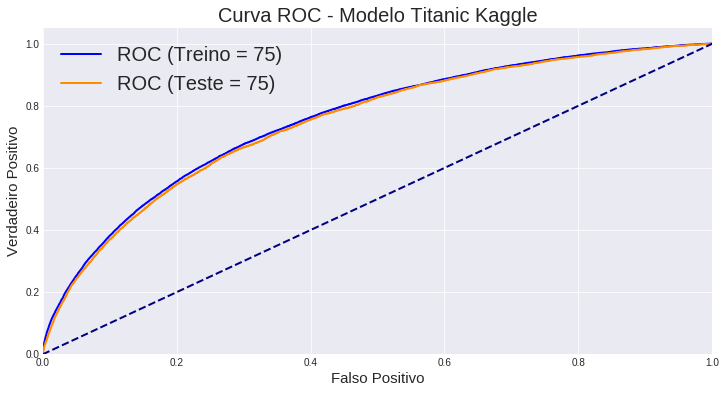

Acurácia, Gini e Área Curva ROC (Base de Treino):  91.93 50.0 75.0
Acurácia, Gini e Área Curva ROC (Base de Teste):  92.04 50.0 75.0


In [58]:
# 1) Cálculo da acurácia
from sklearn.metrics import accuracy_score

#Treino
acc_gbc_train = round(accuracy_score(y_pred_gbc_train, y_train) * 100, 2)

#Teste
acc_gbc_test = round(accuracy_score(y_pred_gbc_test, y_test) * 100, 2)

# 2) Cálculo da área sob curva ROC e Gini
from sklearn.metrics import roc_curve, auc

# Treino
fpr_gbc_train, tpr_gbc_train, thresholds = roc_curve(y_train, y_score_gbc_train)
roc_auc_gbc_train = 100*round(auc(fpr_gbc_train, tpr_gbc_train), 2)
gini_gbc_train = 100*round((2*roc_auc_gbc_train/100 - 1), 2)

# Teste
fpr_gbc_test, tpr_gbc_test, thresholds = roc_curve(y_test, y_score_gbc_test)
roc_auc_gbc_test = 100*round(auc(fpr_gbc_test, tpr_gbc_test), 2)
gini_gbc_test = 100*round((2*roc_auc_gbc_test/100 - 1), 2)


# 3) Gráfico da curva ROC
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(12,6))

lw = 2

plt.plot(fpr_gbc_train, tpr_gbc_train, color='blue',lw=lw, label='ROC (Treino = %0.0f)' % roc_auc_gbc_train)
plt.plot(fpr_gbc_test, tpr_gbc_test, color='darkorange',lw=lw, label='ROC (Teste = %0.0f)' % roc_auc_gbc_test)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivo', fontsize=15)
plt.ylabel('Verdadeiro Positivo', fontsize=15)
plt.legend(loc="lower right")
plt.legend(fontsize=20) 
plt.title('Curva ROC - Modelo Titanic Kaggle', fontsize=20)
plt.show()

print('Acurácia, Gini e Área Curva ROC (Base de Treino): ',acc_gbc_train, gini_gbc_train, roc_auc_gbc_train)
print('Acurácia, Gini e Área Curva ROC (Base de Teste): ',acc_gbc_test, gini_gbc_test, roc_auc_gbc_test)

In [ ]:
#### Marcando Score do Gra

In [60]:
ABT_df_st = ABT_df.drop(['target'], axis=1)

In [62]:
ABT_df_st.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0.142129,-0.478095,-0.166149,-0.507465,-0.149452,0.379837,0.000000,-1.265724,-3.006518e+00,-1.317463,...,-0.00255,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305
1,0.426792,1.725450,0.592677,1.600698,-1.252750,1.078697,0.000000,-0.167639,-1.369223e+00,0.565106,...,-0.00255,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305
2,-0.427196,-1.152888,-1.404676,-1.092389,-0.783451,0.206116,2.001029,-1.265724,-1.592919e-15,0.217545,...,-0.00255,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305
3,-0.142533,-0.711430,0.177869,-0.653696,-0.928991,-1.375829,0.000000,-0.167639,-1.592919e-15,0.712841,...,-0.00255,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305
4,-0.199466,-0.213734,-0.361755,-0.068772,0.563570,0.191639,0.000000,-1.265724,-1.592919e-15,-1.004190,...,-0.00255,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305


In [65]:
y = gbc.predict_proba(ABT_df_st)

In [68]:
ABT_df_st['Score_GB'] = y[:,1]
ABT_df_st.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,...,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,Score_GB
0,0.142129,-0.478095,-0.166149,-0.507465,-0.149452,0.379837,0.000000,-1.265724,-3.006518e+00,-1.317463,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0.468853
1,0.426792,1.725450,0.592677,1.600698,-1.252750,1.078697,0.000000,-0.167639,-1.369223e+00,0.565106,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0.056383
2,-0.427196,-1.152888,-1.404676,-1.092389,-0.783451,0.206116,2.001029,-1.265724,-1.592919e-15,0.217545,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0.037710
3,-0.142533,-0.711430,0.177869,-0.653696,-0.928991,-1.375829,0.000000,-0.167639,-1.592919e-15,0.712841,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0.079132
4,-0.199466,-0.213734,-0.361755,-0.068772,0.563570,0.191639,0.000000,-1.265724,-1.592919e-15,-1.004190,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0.085994


In [76]:
from collections import OrderedDict
dfteste = pd.DataFrame(data = gbc.feature_importances_, columns = ['Imp'])

df = pd.DataFrame(OrderedDict({'Variaveis':x_train.columns,'Importancia':gbc.feature_importances_}))
df = df.sort_values(by='Importancia', ascending=False)
df.head(100)

,Variaveis,Importancia
10,EXT_SOURCE_3,0.339244
9,EXT_SOURCE_2,0.324755
8,EXT_SOURCE_1,0.106083
66,DAYS_BIRTH,0.044129
3,AMT_GOODS_PRICE,0.033935
1,AMT_CREDIT,0.025609
67,DAYS_EMPLOYED,0.019943
2,AMT_ANNUITY,0.016476
85,FLAG_DOCUMENT_3,0.014713
6,OWN_CAR_AGE,0.008952


In [77]:
df.shape

(104, 2)